In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [2]:
# Download dataset dari kaggle
!kaggle datasets download -d madisona/translated-animals10

 96% 560M/586M [00:02<00:00, 302MB/s]
100% 586M/586M [00:02<00:00, 246MB/s]


In [3]:
# Mengekstrak file zip
!mkdir animals
!unzip -qq translated-animals10.zip -d animals
!ls animals

animals10


In [4]:
import os
animals = os.path.join('/content/animals/animals10/raw-img/')

print(os.listdir(animals))

['cat', 'cow', 'chicken', 'squirrel', 'elephant', 'horse', 'butterfly', 'sheep', 'dog', 'spider']


In [ ]:
# menghapus beberapa label
import shutil

delete_animals = ['elephant', 'sheep', 'horse', 'cat', 'cow', 'butterfly']

for x in delete_animals:
  path = os.path.join(animals, x)
  shutil.rmtree(path)

In [14]:
from PIL import Image
total = 0
list_animals = os.listdir(animals)

for x in list_animals:
  dir = os.path.join(animals, x)
  y = len(os.listdir(dir))
  print(x+':', y)
  total = total + y
  
  img_name = os.listdir(dir)
  for z in range(4):
    img_path = os.path.join(dir, img_name[z])
    img = Image.open(img_path)
    print('-',img.size)
  print('-----------------')

print('Total :', total)

chicken: 3098
- (300, 169)
- (300, 225)
- (300, 224)
- (300, 225)
-----------------
squirrel: 1862
- (300, 225)
- (245, 300)
- (300, 264)
- (271, 194)
-----------------
dog: 4863
- (300, 225)
- (201, 300)
- (300, 200)
- (300, 288)
-----------------
spider: 4821
- (300, 229)
- (300, 224)
- (300, 200)
- (300, 201)
-----------------
Total : 14644


<function matplotlib.pyplot.show(*args, **kw)>

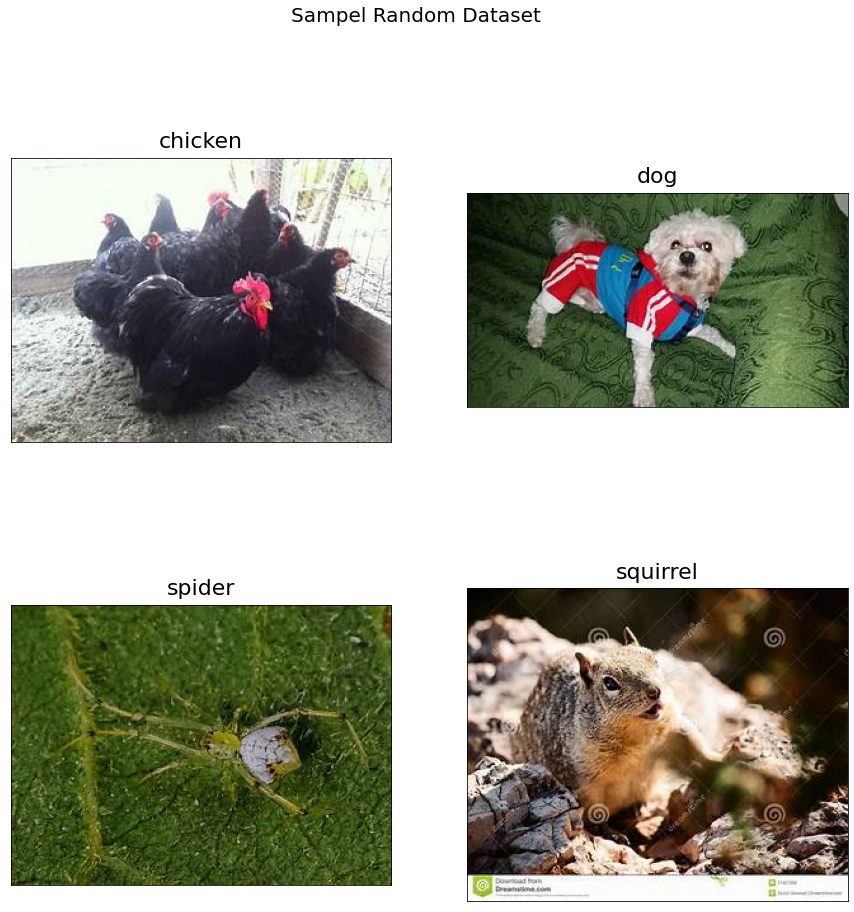

In [15]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, figsize=(15,15))
fig.suptitle("Sampel Random Dataset", fontsize=20)
animals_sorted = sorted(list_animals)
animals_id = 0
for i in range(2):
  for j in range(2):
    try:
      animals_selected = animals_sorted[animals_id] 
      animals_id += 1
    except:
      break
    if animals_selected == '.TEMP':
        continue
    animals_selected_images = os.listdir(os.path.join(animals, animals_selected))
    animals_selected_random = np.random.choice(animals_selected_images)
    img = plt.imread(os.path.join(animals, animals_selected, animals_selected_random))
    ax[i][j].imshow(img)
    ax[i][j].set_title(animals_selected, pad=10, fontsize=22)
    
plt.setp(ax, xticks=[],yticks=[])
plt.show

In [16]:
# Image Data Generator
train_datagen = ImageDataGenerator(
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    rescale = 1/255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode='nearest',
    validation_split = 0.2)

batch_size = 300

data_train = train_datagen.flow_from_directory(
    animals,
    target_size = (150, 150),
    batch_size = batch_size,
    class_mode = 'categorical',
    subset='training'
    )

data_val = train_datagen.flow_from_directory(
    animals, 
    target_size = (150, 150),
    batch_size = batch_size,
    class_mode = 'categorical',
    subset = 'validation'
    )

Found 11717 images belonging to 4 classes.
Found 2927 images belonging to 4 classes.


In [17]:
import tensorflow as tf
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5), 
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 74, 74, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 17, 17, 128)     

In [18]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics = ['accuracy'])

In [19]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.92):
      print("Training dihentikan karena sudah mencapai 92%")
      self.model.stop_training = True

callbacks = myCallback()

In [23]:
# Melatih Model
history = model.fit(data_train, 
                    epochs = 50, 
                    steps_per_epoch = 35,
                    validation_data = data_val, 
                    validation_steps = 5,
                    verbose = 2,
                    callbacks = [callbacks])

Epoch 1/50
35/35 - 74s - loss: 0.6746 - accuracy: 0.7504 - val_loss: 0.5973 - val_accuracy: 0.7840 - 74s/epoch - 2s/step
Epoch 2/50
35/35 - 73s - loss: 0.6342 - accuracy: 0.7598 - val_loss: 0.6388 - val_accuracy: 0.7600 - 73s/epoch - 2s/step
Epoch 3/50
35/35 - 72s - loss: 0.6208 - accuracy: 0.7665 - val_loss: 0.5812 - val_accuracy: 0.7880 - 72s/epoch - 2s/step
Epoch 4/50
35/35 - 75s - loss: 0.5808 - accuracy: 0.7846 - val_loss: 0.5540 - val_accuracy: 0.7987 - 75s/epoch - 2s/step
Epoch 5/50
35/35 - 75s - loss: 0.5459 - accuracy: 0.7974 - val_loss: 0.5437 - val_accuracy: 0.7840 - 75s/epoch - 2s/step
Epoch 6/50
35/35 - 72s - loss: 0.5663 - accuracy: 0.7899 - val_loss: 0.6088 - val_accuracy: 0.7660 - 72s/epoch - 2s/step
Epoch 7/50
35/35 - 73s - loss: 0.5975 - accuracy: 0.7748 - val_loss: 0.5419 - val_accuracy: 0.8020 - 73s/epoch - 2s/step
Epoch 8/50
35/35 - 73s - loss: 0.5312 - accuracy: 0.8036 - val_loss: 0.5643 - val_accuracy: 0.7973 - 73s/epoch - 2s/step
Epoch 9/50
35/35 - 72s - loss: 0

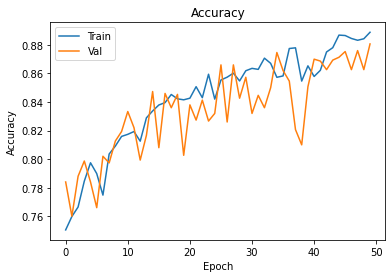

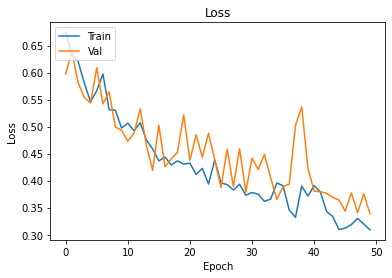

In [27]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [28]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [29]:
!ls -la | grep 'model'

-rw-r--r-- 1 root root  13900316 Sep  8 05:20 model.tflite


In [31]:
model.save('model_deploy_klasifikasi_gambar.pb') 
%cd

/root
